## Analysis of WeChat friends

### Data source
Get information of friends through scanning the QR code wxpy offered and then it loads the contact.

### Analysis
1. Sex proportions of friends
2. The locations where friends are, including cities and provinces
3. The most frequent words from signatures

In [1]:
import re
from wxpy import *
import jieba
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
import gmplot
from matplotlib.patches import Polygon
from matplotlib.colors import rgb2hex
from langconv import *
import folium
from folium.plugins import HeatMap

%matplotlib inline

In [2]:
# initialize the bot and scan the QR code
bot = Bot()

# get the information of friends
my_friends = bot.friends()
print(type(my_friends))

Getting uuid of QR code.
Please scan the QR code to log in.
Please press confirm on your phone.
Loading the contact, this may take a little while.
Login successfully as 范梅


<class 'wxpy.api.chats.chats.Chats'>


In [3]:
my_friends[0].raw

{'Alias': '',
 'AppAccountFlag': 0,
 'AttrStatus': 4294053,
 'ChatRoomId': 0,
 'City': '厦门',
 'ContactFlag': 5,
 'DisplayName': '',
 'EncryChatRoomId': '',
 'HeadImgFlag': 1,
 'HeadImgUrl': '/cgi-bin/mmwebwx-bin/webwxgeticon?seq=678111631&username=@ef15d73c7f3de3032edf38bb70948ac1&skey=@crypt_15eb1cad_4884c36b0d49023ae3060f4967033e8d',
 'HideInputBarFlag': 0,
 'IsOwner': 0,
 'KeyWord': 'fan',
 'MemberCount': 0,
 'MemberList': [],
 'NickName': '范梅',
 'OwnerUin': 0,
 'PYInitial': 'FM',
 'PYQuanPin': 'fanmei',
 'Province': '福建',
 'RemarkName': '',
 'RemarkPYInitial': '',
 'RemarkPYQuanPin': '',
 'Sex': 2,
 'Signature': '嬉皮笑脸地面对人生的难',
 'SnsFlag': 49,
 'StarFriend': 0,
 'Statues': 0,
 'Uin': 1039718600,
 'UniFriend': 0,
 'UserName': '@ef15d73c7f3de3032edf38bb70948ac1',
 'VerifyFlag': 0,
 'WebWxPluginSwitch': 0}

LOG OUT!


Even though there's a lot of informaiton, actually we can only pull out some of them, such as city, NickName, sex etc.    
For this analysis, only <b>sex</b>, <b>city</b>, <b>province</b> and <b>signature</b> will be in discussion.

#### 1. Sex proportion   
Pull out the sex infomation and draw pie chart

In [4]:
# count the numbers of sexes and convert it into DataFrame
def find_out_sex(raw):
    sex_counts = defaultdict(int)
    for friend in my_friends:
        if friend.sex == 1:
            sex_counts['male'] += 1
        elif friend.sex == 2:
            sex_counts['female'] += 1
        else:
            sex_counts['other'] += 1
    df_sex = pd.DataFrame(list(sex_counts.items()),columns=['sex','count'])
    
    return sex_counts, df_sex

sex_counts, df_sex = find_out_sex(my_friends)

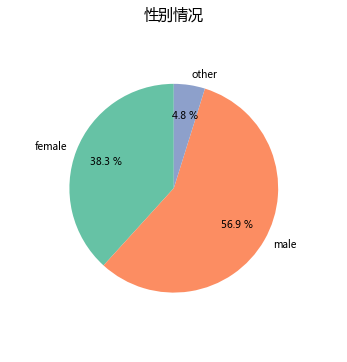

In [5]:
# draw pie charts
sns.set_palette('Set2')

fig = plt.figure(figsize=(8,6))

labels = df_sex.sex  #use the sex as lables
plt.axes(aspect=1)  # set this to make a round figure

plt.title("性别情况",fontdict={'fontsize':15},loc='center')  

plt.pie(data=df_sex, x='count', labels=labels, autopct='%3.1f %%', radius=0.8,
        labeldistance=1.1, startangle = 90, pctdistance = 0.7)
plt.show()
# fig.savefig('friendsex.png', dpi=fig.dpi);

From the pie chart, we can see that more than half of my friends are male, and the female is only 38% though there's still some of my friends who don't want to show the sex info.    
In my opinion, it is because there are many of my customers in the past that are male.    
If you know me, you will agree I am quite popular both in female and male.

#### 2. Location -city    
Pull out the city location infomation and draw a basemap with sizable scatter and a heatmap

In [6]:
# pull out location city data into DataFrame
def obtain_city_data(raw):
    # create cities dict to store unique city names and counts
    cities_dict = defaultdict(int)
    for friend in raw:
        city = friend.city
        cities_dict[city] += 1
    
    # convert the dictionary data into DataFrame
    df_city = pd.DataFrame(list(cities_dict.items()),columns=['city','count'])
    df_city['city'] = df_city['city'].apply(lambda x: 'Others' if x=='' else x)
    
    # groupby column city in case there's duplicate city items.
    df_city_unique = df_city.groupby('city').sum()
    #print(df_city_unique['count'].sum())   #check the total number
    df_city_unique = df_city_unique.reset_index()  # make sure the data is still in DataFrame
    
    return df_city_unique

df_city_unique = obtain_city_data(my_friends)    

In [7]:
df_city_unique.isnull().sum().sort_values(ascending=False)

count    0
city     0
dtype: int64

To check if the data have null values and it passed.

In [8]:
# load the lon/lat info of cities to prepare to draw map
city_lt = pd.read_csv('/Users/mabelfan/Documents/supports/城市经纬度.csv')
city_lt_copy = city_lt.copy()

In [9]:
#Merge the city_data with the lon/lat info
df_city_lt = df_city_unique.merge(city_lt_copy, how='left',\
                                  left_on = 'city', right_on ='city')

# delete the rows that still don't have lat and log information as there are some friends not Chinese
df_city_lt_nonna = df_city_lt.dropna()

#print(df_city_lt['count'].sum(),'\n',df_city_lt_nonna['count'].sum())


In [10]:
# search the lat/log info for the cities not included in original data and convert it to DataFrame
# city_lt = {'经度':[106.429500,34.030000,121.500000,100.230000,121.250000,116.300000,121.470000,116.370000,116.420000,121.270000],\
#           '纬度':[29.833700,118.150000,25.050000,25.600000,25.030000,39.950000,31.230000,39.920000,39.930000,31.380000],\
#          'city':['北碚','Los Angeles','台北市','大理','桃园县','海淀','黄浦','西城','东城','嘉定']}
# df_city_add = pd.DataFrame(city_lt)

# delete the last word '市' to better concat
#city_lt_copy['city'] = city_lt_copy['地级以上城市'].apply(lambda x: x[:-1] if x[-1] == '市' else x)

#concat the added lat/log info with the orignal one and save it locally
#city_lt =  pd.concat([city_lt_copy, df_city_add], ignore_index=True)
#city_lt.to_csv('../城市经纬度.csv',index=False)  # attention to not keep the index column

In [11]:
latitude = list(df_city_lt_nonna['纬度'])
longitude = list(df_city_lt_nonna['经度'])

# Place map
gmap = gmplot.GoogleMapPlotter(latitude[0],longitude[0], 16)

# personal moving line
latitude1=[27.795574,29.833700,22.556396,24.457436,27.795574]
longitude1=[114.374611,106.429500,114.110672,118.087517,114.374611]
gmap.plot(latitude1, longitude1, 'cornflowerblue', edge_width=10)

# Marker
hidden_gem_lat, hidden_gem_lon = 118.101897,24.576368
gmap.marker(hidden_gem_lat, hidden_gem_lon, 'cornflowerblue')

# Write the map in an HTML file, as it connects to Google map, needs VPN to open it.
gmap.draw('my_loc_map.html')

#gmap.scatter(latitude, longitude, '#3B0B39', size=40, marker=False)
#gmap.draw("mymap1.html")   

#gmap.scatter(latitude, longitude, 'k', marker=True)
#gmap.draw("mymap2.html")

#gmap.heatmap(latitude, longitude)
#gmap.draw("mymap3.html")


In [12]:
 # get the lats and lons
lat = np.array(df_city_lt_nonna['纬度'])                       
lon = np.array(df_city_lt_nonna['经度'])  

#get the population of each city located and change the type to float for calculation
pop = np.array(df_city_lt_nonna['count'],dtype=float)  

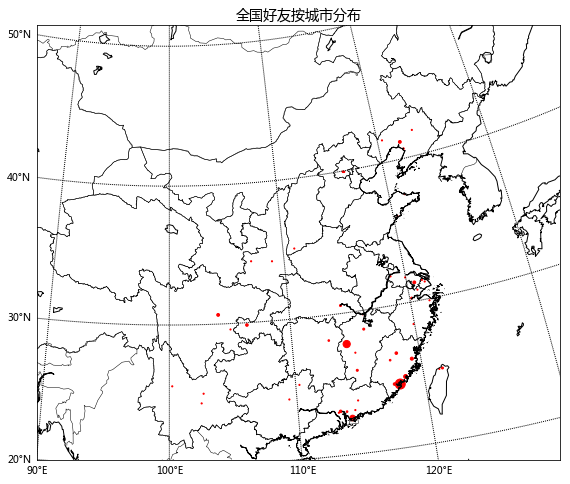

In [13]:
fig = plt.figure(figsize=(12,8))        

# decide the size of scatter
size=(pop/np.max(pop))*100   

# draw map according to the given lon/lat
map = Basemap(llcrnrlon=90, llcrnrlat=20, urcrnrlon=140,urcrnrlat=45,\
              projection='stere', lat_0=35, lon_0=100, resolution='l')

map.drawcoastlines()   
map.drawcountries()    

# read province of Chinese map
map.readshapefile('gadm36_CHN_shp/gadm36_CHN_1', 'states', drawbounds=True)

# as it will grows to complicated, made the drawbounds to False for the cities and taiwan_cities
map.readshapefile('gadm36_CHN_shp/gadm36_CHN_2', 'cities', drawbounds=False)
map.readshapefile('gadm36_TWN_shp/gadm36_TWN_2', 'taiwan2', drawbounds=False)

#draw parallels
parallels = np.arange(0.,90,10.) 
map.drawparallels(parallels,labels=[1,0,0,0],fontsize=10) # 绘制纬线

#draw meridians
meridians = np.arange(80.,140.,10.)
map.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10) # 绘制经线

# compute map projection coordinates for lat/lon grid.
x,y = map(lon,lat)

# draw scatter according to the city distribution of friends
map.scatter(x,y,edgecolors='r',facecolors='r',marker='o',s=size)

plt.title('全国好友按城市分布',fontdict={'fontsize':14},loc='center')

plt.show()


The bigger the scatters are, the more friends that are located in that area.   
The first area that I have the most number of friends is Xiamen, next is my hometown-Yichun.   
Besides, the areas that I have ever lived have a more sigficant scatter, such as ChongQing, Shenzhen.   
Also, the developed areas have more friends than the rest other places.

In [14]:
def draw_city():
    fig = plt.figure(figsize=(16,9))

    # only show China map
    m = Basemap(llcrnrlon=77, llcrnrlat=14, urcrnrlon=140, urcrnrlat=51, \
                projection='lcc', lat_1=33, lat_2=45, lon_0=100)

    # readshapefile, make sure which file you want to read in the gadm36_CHN_shp folder
    m.readshapefile('gadm36_CHN_shp/gadm36_CHN_2', 'cities', drawbounds=True)

    m.readshapefile('gadm36_TWN_shp/gadm36_TWN_2', 'taiwan2', drawbounds=True)

    ax = plt.gca()
    for info, shp in zip(m.cities_info, m.cities):
        city = info['NL_NAME_2']
        poly = Polygon(shp,edgecolor='c')
        ax.add_patch(poly)
    
    for info, shp in zip(m.taiwan2_info, m.taiwan2):
        city = info['NL_NAME_2']
        poly = Polygon(shp,edgecolor='c')
        ax.add_patch(poly)
    
    plt.show()

#draw_city()

In [15]:
num = len(df_city_lt_nonna)

# make a city location and count of friends to be a list of lat,lon and pop, then store all this data into a list
data1 = [[lat[i],lon[i],pop[i]] for i in range(num)]    

# draw a map with a start location and make the zoom to be 5
map_osm = folium.Map(location=[32,110],zoom_start=5,control_scale=True)    

# draw HeatMap and add it to map_osm
HeatMap(data1).add_to(map_osm) 

#mark my locaiton and add to the map drawed
folium.Marker([24.457436,118.087517],popup='Xiamen',
              icon=folium.Icon(icon='cloud')).add_to(map_osm)

# draw my routines from hometown to college city to first work city and now
ls = folium.PolyLine(locations=[[27.795574,114.374611],[29.833700,106.429500],\
                                [22.556396,114.110672],[24.457436,118.087517]],color='blue')

ls.add_to(map_osm)

map_osm
#map_osm.save('friend_dist.html')     

Similar as the previous basemap, in addition, I displayed the routine of cities in my past few years.

#### 2. Locations -Province
Similar as city analysis.    
The reason why I defined an almost a same func obtain_province_data as obtain_city_data is that the attribute <b>city</b> and <b>province</b> are not allowed to present as a variable to my_friends...

In [16]:
def obtain_province_data(raw):
    # create cities dict to store unique city names and counts
    pro_dict = defaultdict(int)
    for friend in raw:
        pro = friend.province
        if pro == '':
            pro_dict['其他'] += 1
        else:
            pro_dict[pro] += 1
    
    # convert the dictionary data into DataFrame
    df_pop = pd.DataFrame(list(pro_dict.items()),columns=['province','count'])
    df_pop['省名'] = df_pop['province'].apply([lambda x: x.replace(" ","")])
    df_pop.set_index('省名', inplace=True)
    return df_pop

df_pop = obtain_province_data(my_friends)

In [17]:
# check if the total number of friends is consistant
#df_pop['count'].sum()

In [18]:
df_pop.isnull().sum().sort_values(ascending=False)

count       0
province    0
dtype: int64

好友总数确认无误；   
缺失值通过isnull()确认不存在。       

In [19]:
def get_pro(info):
    pro = info.split('|')
    if len(pro) > 1:
        s = pro[1]
    else:
        s = pro[0]
    s = s[:2]
    if s == '黑龍':
        s = '黑龙江'
    if s == '内蒙':
        s = '内蒙古'
    return s

In [20]:
def Traditional2Simplified(sentence):
    '''
    将sentence中的繁体字转为简体字
    :param sentence: 待转换的句子
    :return: 将句子中繁体字转换为简体字之后的句子
    '''
    return Converter('zh-hans').convert(sentence)
    

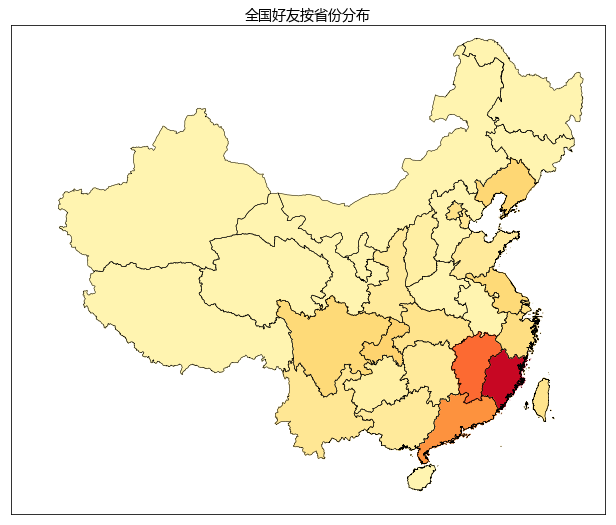

In [21]:
fig = plt.figure(figsize=(16,9))

#m = Basemap()

# only show China map
m = Basemap(llcrnrlon=77, llcrnrlat=14, urcrnrlon=140, urcrnrlat=51, \
            projection='lcc', lat_1=33, lat_2=45, lon_0=100)

# readshapefile, make sure which file you want to read in the gadm36_CHN_shp folder
m.readshapefile('gadm36_CHN_shp/gadm36_CHN_1', 'states', drawbounds=True)

m.readshapefile('gadm36_TWN_shp/gadm36_TWN_0', 'taiwan', drawbounds=True)

# draw coast lines
#m.drawcoastlines()

# draw country lines
#m.drawcountries(linewidth=1.5)

#ax = plt.gca()
#for nshape, seg in enumerate(m.states):
#    poly = Polygon(seg, facecolor='r')
#    ax.add_patch(poly)

cmap = plt.cm.YlOrRd
vmax = 1500
vmin = -10

ax = plt.gca()
for info, shp in zip(m.states_info, m.states):
    state = info['NL_NAME_1']
    proid = get_pro(state)
    if proid not in df_pop['province']:
        pop = 0
    else:
        pop = df_pop['count'][proid]*10
    color = rgb2hex(cmap(np.sqrt((pop - vmin) / (vmax - vmin)))[:3])
    poly = Polygon(shp,facecolor=color,edgecolor=color)
    ax.add_patch(poly)

for nshape, shp in enumerate(m.taiwan):
    pop = df_pop['count']['台湾']*10
    color = rgb2hex(cmap(np.sqrt((pop - vmin) / (vmax - vmin)))[:3])
    poly = Polygon(shp,facecolor=color,edgecolor=color)
    ax.add_patch(poly)

plt.title('全国好友按省份分布',fontdict={'fontsize':14},loc='center')
    
plt.show();

From the map we can see, the first three provinces that I have the majority of my friends is Fujian, Jiangxi and Guangdong, next is ChongQing, Sichun, Liaoning and Jiangsu.

#### 3. The most frequent words from signatures     
There may be some friends that don't ever have a signature, but it does no matter.   
We just pull out what we have and count the frequency of the words, then draw a wordcloud.

In [22]:
#pull out the signatures, delete the words likt span，class，emoji，emoji1f3c3 etc
signatures = []
for i in my_friends[1:]:
    signature = i.signature.strip().replace("span", "").replace("class", "").replace("emoji", "")
# use re to delete emoticons ,like emoji1f3c3
    reg1 = re.compile("1f\d.+")
    reg2 = re.compile('\s*') 
    signature = reg2.sub("", reg1.sub("", signature))
    if len(signature) > 0:
        signatures.append(signature)

# join all the words
text = "".join(signatures)

In [23]:
# jieba to divide sentences to words

stopwords = {}.fromkeys([line.rstrip() for line in open('/Users/mabelfan/Documents/supports/stopwords.txt','r')])
wordlist_jieba = jieba.cut(text, cut_all=False)

#wl_space_split = " ".join(wordlist_jieba)

final = ''
for word in wordlist_jieba:
    if word not in stopwords:
        final += word
        final += " "

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/yz/qcyb2b3n46j6_vlgcyy_n67w0000gn/T/jieba.cache
Loading model cost 0.970 seconds.
Prefix dict has been built succesfully.


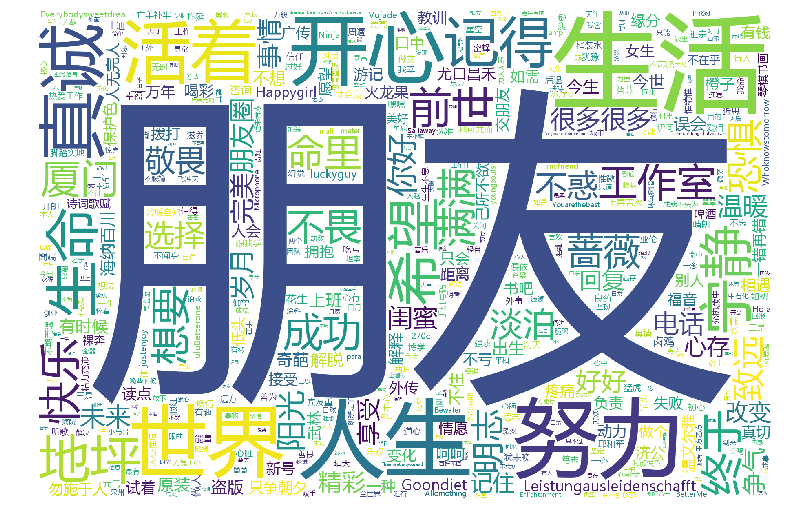

In [24]:
plt.rcParams['font.sans-serif']=['Microsoft YaHei'] 

# Generate a word cloud image
font = r'/Library/Fonts/msyh.ttf'
wordcloud = WordCloud(background_color="white",font_path=font, 
                        width=1800, height=1200,max_words=2000, max_font_size=800,).generate(final)
fig = plt.figure(figsize=(16,9))

# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# fig.savefig('friendwords.png', dpi=fig.dpi)

WOW, Got a so big '朋友', it seems that most of my friends care their friends a lot!   
And then is about life, living, world, sincerity, happiness, hardworking and so on.
I am so happy to know the things they care are positive and want to have a better life.   
Cheers!

### Conclusion   
The data quantity is quite small, and the infomation we can got here is limited and almost are category variables. It turns out to be more like a word analysis project compared to data analysis.    
Anyway, It is quite fun and I learned about a lot as well.